<a href="https://colab.research.google.com/github/jindaldisha/self-driving-car/blob/main/Self_Driving_Simulation_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Self Driving Simulation Using CNN

We'll be using Convolutional Neural Network (CNN) to train a self driving car in the open source self driving car simulator that is provided by Udacity. Using this simulator we'll first drive the car and collect some data and using this data we'll train a CNN model proposed by NVIDIA to learn the patterns and then test it back on the simulator.  In the model proposed by NVIDIA, a CNN model that goes beyond pattern recognition was proposed. The model learns the entire pipeline needed to steer an automobile. 

First, the car was driven manually in the Udacity Simulator to collect data. Images from left, center and right camera were captured simultaneously along with the steering, throttle, speed and brake values . But we will only use the images from the center camera and the steering angle along with it. The training data for our model contains single image samples from the simulator paired with the corresponding steering angle command.
The model will train itself based on this data and it will try to learn and generalize as much as it can. 

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import cv2
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

##Import Data

We get a csv file containing all the information along with the images in a folder from the simulator. The folder has been stored on drive. We will first create a function to get the csv file into a pandas dataframe and then store only the center camera image paths and steering angles in seperate numpy arrays.

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzip the driving log file
# !unzip '/content/drive/MyDrive/Colab Notebooks/self_driving_car/driving_logs_2.zip' -d '/content/drive/MyDrive/Colab Notebooks/self_driving_car/driving_logs_2'

In [ ]:
 #Function to import data
def import_data_info(path):
  columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
  df = pd.read_csv(path + '/driving_log.csv', names = columns)
  return df

In [ ]:
#Define path
path = '/content/drive/MyDrive/Colab Notebooks/self_driving_car/driving_logs'

#Import data
dataset = import_data_info(path)

In [ ]:
dataset.shape

(826, 7)

In [ ]:
#View df
dataset.head()

,Center,Left,Right,Steering,Throttle,Brake,Speed
0,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000003
1,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000007
2,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000004
3,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000019
4,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000009


##Initialize Data

The images have the full file path name that it was stored in, on the computer. We will remove the filepath and only keep the image name.

In [ ]:
dataset['Center'][0]

'C:\\Users\\disha\\Coding\\Self Driving Car\\driving_logs\\IMG\\center_2021_07_18_12_08_31_833.jpg'

In [ ]:
dataset['Center'][0].split('\\')

['C:',
 'Users',
 'disha',
 'Coding',
 'Self Driving Car',
 'driving_logs',
 'IMG',
 'center_2021_07_18_12_08_31_833.jpg']

In [ ]:
dataset['Center'][0].split('\\')[-1]

'center_2021_07_18_12_08_31_833.jpg'

In [ ]:
def get_name(path):
  return path.split('\\')[-1]

In [ ]:
temp = get_name(dataset['Center'][0])

In [ ]:
temp

'center_2021_07_18_12_08_31_833.jpg'

In [ ]:
#Apply function to the whole column
dataset['Center'] = dataset['Center'].apply(get_name)

In [ ]:
dataset.head()

,Center,Left,Right,Steering,Throttle,Brake,Speed
0,center_2021_07_18_12_08_31_833.jpg,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000003
1,center_2021_07_18_12_08_31_928.jpg,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000007
2,center_2021_07_18_12_08_32_024.jpg,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000004
3,center_2021_07_18_12_08_32_121.jpg,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000019
4,center_2021_07_18_12_08_32_220.jpg,C:\Users\disha\Coding\Self Driving Car\driving...,C:\Users\disha\Coding\Self Driving Car\driving...,0.0,0.0,0,0.000009


##Visualize and Balance Data

We will visualize and balance our data to make sure the training process is not biases. We don't want our data to be too unbalance because we won't get optimized results for the class which is unbalanced in real time as the model will never gets sufficient look at the underlying class. It will also creates a problem of making a validation or test sample as its difficult to have representation across classes in case number of observation for few classes is extremely less.

Our Steering angle is a continuous value, therefore we have a regression problem at our hand. We will split the `Steering` values into bins and plot a bar graph to visualize the distribution.

In [ ]:
#Function to view bar graph distribution of `Steering` values.
def view_data_distribution(data, display = True):
  number_of_bins = 25
  hist, bins = np.histogram(data['Steering'], number_of_bins)
  #Create a center 
  center = (bins[:-1] + bins[1:]) * 0.5
  plt.bar(center, hist, width = 0.05)
  plt.show()

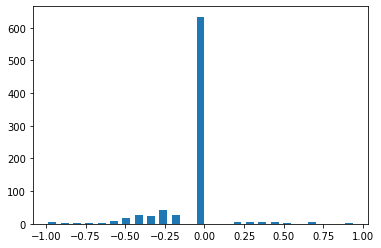

In [ ]:
view_data_distribution(dataset)

From the graph, it can be seen that the data is highly biased and has a lot of values with Steering angle = 0. Most of the time car runs on straight road and therefore for the most part of it, the steering wheel angle is 0. We need to balance the data so that the training can be unbiased. 

In [ ]:
def balance_data(data):
  number_of_bins = 25
  number_of_elements = 1000
  hist, bins = np.histogram(data['Steering'], number_of_bins)
  number_of_bins = 25
  remove_index_list = []
  for j in range(number_of_bins):
    bin_data = []
    for i in range(len(data['Steering'])):
      if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j+1]:
        bin_data.append(i)
    bin_data = shuffle(bin_data)
    bin_data = bin_data[number_of_elements:]
    remove_index_list.extend(bin_data)
  print('Original Number of Images: ', len(data))  
  print('Removed Images:', len(remove_index_list))
  data.drop(data.index[remove_index_list], inplace = True)
  print('Remaining Images: ', len(data))
  return data

In [ ]:
balanced_dataset = balance_data(dataset)

Original Number of Images:  826
Removed Images: 0
Remaining Images:  826


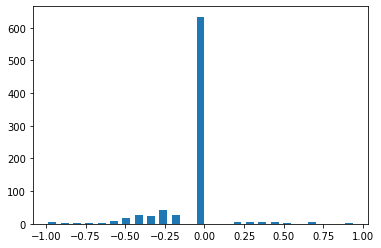

In [ ]:
#Data distribution of balanced data
view_data_distribution(balanced_dataset)

##Prepare for Processing

We're going to put all the images in one list and all the steering values in another list. Then we will convert it into numpy arrays.

In [ ]:
def load_data(path, data):
  image_path = []
  steering_path = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    image_path.append(path + 'IMG/' + indexed_data[0])
    steering_path.append(float(indexed_data[3]))

  image_path = np.asarray(image_path)
  steering_path = np.asarray(steering_path)
  return image_path, steering_path

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/self_driving_car/driving_logs/'

image_path, steering_path = load_data(path, dataset)

In [ ]:
image_path[0], steering_path[0]

('/content/drive/MyDrive/Colab Notebooks/self_driving_car/driving_logs/IMG/center_2021_07_18_12_08_31_833.jpg',
 0.0)

##Traning and Validatin Sets

We will divide our model into training and validation sets.

- **Training Dataset**: The sample of data used to fit the model.
The actual dataset that we use to train the weights and biases. The model sees and learns from this data.

- **Validation Dataset**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

In [ ]:
#Splitting into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(image_path, steering_path, test_size = 0.2, random_state = 5)

In [ ]:
print('Training Size: ', len(x_train))
print('Validation Size: ', len(x_valid))

Training Size:  660
Validation Size:  166


##Data Augmentation

Data Augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

We will modify the following properties of our images to add augmentation:
- Pan
- Zoom
- Brightness
- Flip

In [ ]:
#Take an image example
sample_image = mpimg.imread(image_path[0])
sample_steering = steering_path[0]

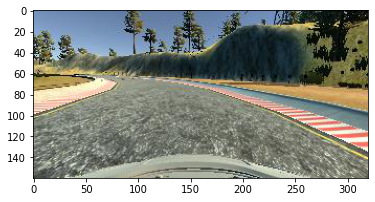

In [ ]:
plt.imshow(sample_image);

###Pan

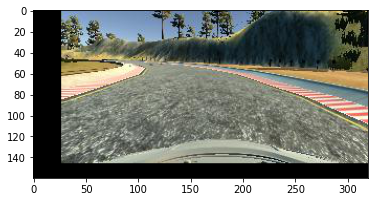

In [ ]:
#Pan
pan = iaa.Affine(translate_percent={'x':(-0.1,0.1), 'y':(-0.1, 0.1)})
translated_image = pan.augment_image(sample_image)
plt.imshow(translated_image);

###Zoom

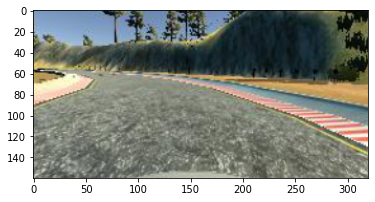

In [ ]:
#Zoom
zoom = iaa.Affine(scale = (1, 1.3))
zoomed_image = zoom.augment_image(sample_image)
plt.imshow(zoomed_image);

###Brightness

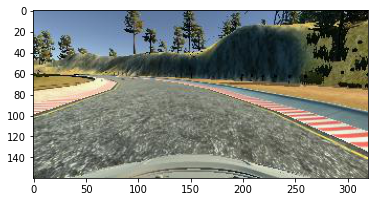

In [ ]:
#Brightness
brightness = iaa.Multiply((0.5, 1.3))
brightened_image = brightness.augment_image(sample_image)
plt.imshow(brightened_image);

###Flip

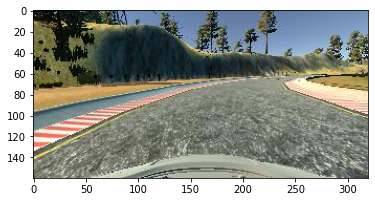

In [ ]:
#Flip
flipped_image = cv2.flip(sample_image, 1)
plt.imshow(flipped_image);

Now we will create a function to randomly apply any of these augmentation techniques on the images. To get this randomness, we will generate a random number and perform the operation depending on that number.

In [ ]:
#Function for data augmentation
def augmentation(path, steering):
  image = mpimg.imread(path)
  if np.random.rand() > 0.5:
    #Pan
    pan = iaa.Affine(translate_percent={'x':(-0.1,0.1), 'y':(-0.1, 0.1)})
    image = pan.augment_image(image)
  if np.random.rand() > 0.5:
    #Zoom
    zoom = iaa.Affine(scale = (1, 1.3))
    image = zoom.augment_image(image)
  if np.random.rand() > 0.5:
    #Brightness
    brightness = iaa.Multiply((0.5, 1.3))
    image = brightness.augment_image(image)
  if np.random.rand() > 0.5:
    #Flip
    flipped_image = cv2.flip(image, 1)
    steering = -steering
  return image, steering


Augmented Steering:  -0.0


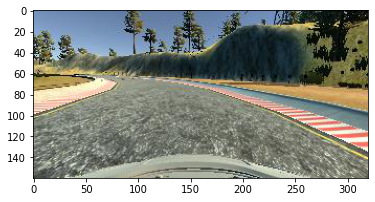

In [ ]:
#Apply the augmentation function on an image
augmented_image, augmented_steering = augmentation(image_path[0], steering_path[0])
plt.imshow(augmented_image)
print('Augmented Steering: ', augmented_steering)

##Preprocessing

There are a couple of steps we need to take the images before they're ready to be fed into the model.
- **Crop**: The images need to be cropped because we don't want the car itself or the mountains in the background in the image. Therefore we can crop out only the road region so that we don't get any other details that are not required.
- **YUV Colorspace**: We will change our colorspace from RGB to YUV. We do this because the lane-lines become more visible in the YUV colorspace and the path becomes clearer. This increase the generalization of our model.
-**Blur**: Image blur is a form of degradation which reduces image quality. Deliberately introducing imperfections into our datasets is essential to making our models more resilient to the harsh realities they'll encounter in real world situations.
- **Resize**: All the images need to be the sampe size before they can be formed into batched.
- **Normalization**: Neural Networks prefer data to be scaled. To get better results, we need to normalize our data i.e turn it into range of (0,1). We can normalize our data by dividing it by the max value i.e. dividing it by 255.


###Crop

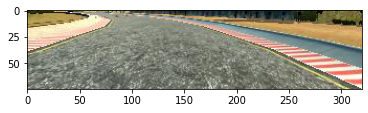

In [ ]:
#Cropping
cropped_image = sample_image[60:135,:,:]
plt.imshow(cropped_image);

###YUV Colorspace

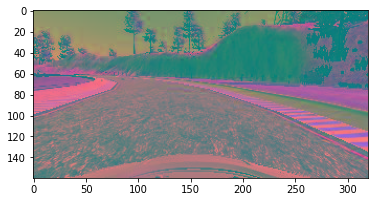

In [ ]:
#YUV Colorspace
yuv_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2YUV)
plt.imshow(yuv_image)

###Blur

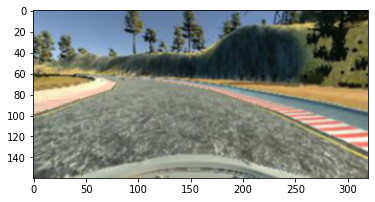

In [ ]:
#Blur
blurred_image = cv2.GaussianBlur(sample_image, 
                                 ksize = (3,3),
                                 sigmaX = 0)
plt.imshow(blurred_image);

###Resize

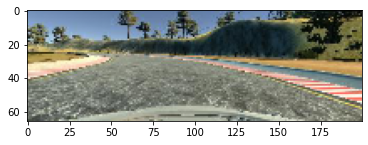

In [ ]:
#Resize
resized_image = cv2.resize(sample_image, (200,66))
plt.imshow(resized_image);

###Normalization

In [ ]:
#Normalization
normalized_image = sample_image/255.
print('Before Normalization: ',
      '\nMax Pixel: ', np.max(sample_image),
      '\nMin Pixel: ', np.min(sample_image))
print('After Normalization: ',
      '\nMax Pixel: ', np.max(normalized_image),
      '\nMin Pixel: ', np.min(normalized_image))

Before Normalization:  
Max Pixel:  255 
Min Pixel:  0
After Normalization:  
Max Pixel:  1.0 
Min Pixel:  0.0


We will now all the operation that we talked about into a single function

In [ ]:
#Function to preprocess the images
def preprocess(image):
    #Crop
    image = image[60:135,:,:]
    #YUV colorspace
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    #Blur
    image = cv2.GaussianBlur(image, 
                                 ksize = (3,3),
                                 sigmaX = 0)
    #Resize
    image = cv2.resize(image, (200,66))
    #Normalize
    image = image/255.
    return image

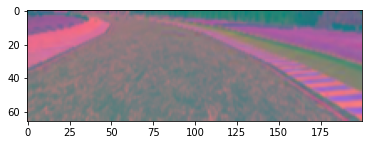

In [ ]:
#Test the preprocessing function on a sample image
preprocessed_image = preprocess(sample_image)
plt.imshow(preprocessed_image)

##Batch Generator

When working with large datasets, its not possible to train the entire dataset at once as it may not fit into the memory and even if it does, the entire process will be very slow. And therefore what we do instead is take the dataset and break it into batches and train our model batch by batch. We're also going to shuffle our dataset to generalize our model.

Since we only need to augment our training images and not our validation images, we will set up a `train_flag` which will be set `True` when passing training images and `False` when passing validation images. This way validation images will only be preprocessed and not augmented whereas training images will be preprocessed as well as augmented.


In [ ]:
def batch_generator(image_path, steering_list, batch_size, train_flag):
  while True:
    #List containing the batches
    image_batch = []
    steering_batch = []
    for i in range(batch_size):
      #Get a random index value
      index = random.randint(0, len(image_path) - 1)

      if train_flag:
        #Apply augmentation function to our image
        image, steering = augmentation(image_path[index], steering_list[index])
      else:
        #Load image and steering angle from the path
        image = mpimg.imread(image_path[index])
        steering = steering_list[index]

      #Apply preprocessing function to image
      image = preprocess(image)
      #Add the preprocessed image to the batch
      image_batch.append(image)
      steering_batch.append(steering)
      #Since it is a generator we yield 
    yield (np.asarray(image_batch), np.asarray(steering_batch))

##Model

We train the weights of our network to minimize the mse (mean squared error) between the steering command output by the network and the command of the human controller. Our network consists of 5 Convolutional layers and 3 full connected Dens layers. The input image is split into YUV planes and passed to our network. In the NVIDIA model, there is also a layer of normalization but we've added that step in our preprocessing function which will be passed to our data while it is being turned into batches, which we will do when we call the batch_generator while we fit the model. The convolutional layers were designed to perform feature extraction. Strided convolutions are used in the first three convolutional layers with a 2x2 stride and a 5x5 kernal and a non-strided convolution with a 3x3 kernel size in the last two convolutional layers. This is because when the images passes throught the 3rd convolutional layer, its dimensionality has already reduces a lot and furthur reducing it will result in an error. 

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
          filters = 24,
          kernel_size = 5,
          strides = 2,
          input_shape = (66, 200, 3),
          activation = 'elu'
        ),
        tf.keras.layers.Conv2D(
            filters = 36,
            kernel_size = 5,
            strides = 2,
            activation = 'elu'
        ),
        tf.keras.layers.Conv2D(
            filters = 48,
            kernel_size = 5,
            strides = 2,
            activation = 'elu'
        ),
        tf.keras.layers.Conv2D(
            filters = 64,
            kernel_size = 3,
            strides = 1,
            activation = 'elu'
        ),
        tf.keras.layers.Conv2D(
            filters = 64,
            kernel_size = 3,
            strides = 1,
            activation = 'elu'
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units = 100,
            activation = 'elu'
        ),
        tf.keras.layers.Dense(
            units = 50,
            activation = 'elu'
        ),
        tf.keras.layers.Dense(
            units = 10,
            activation = 'elu'
        ),
        tf.keras.layers.Dense(1)  

])

In [ ]:
#Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = 'mse',
    metrics = ['mse']
)

In [ ]:
#View Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [ ]:
#Fit the Model
history = model.fit(
    batch_generator(x_train, y_train, 100, True),
    steps_per_epoch = 300,
    epochs = 10,
    validation_data = batch_generator(x_valid, y_valid, 100, False),
    validation_steps = 200
)

Epoch 1/10
300/300 [==============================] - 277s 917ms/step - loss: 0.0477 - mse: 0.0477 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 2/10
300/300 [==============================] - 274s 916ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 3/10
300/300 [==============================] - 272s 910ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 4/10
300/300 [==============================] - 274s 916ms/step - loss: 0.0468 - mse: 0.0468 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 5/10
300/300 [==============================] - 273s 912ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 6/10
300/300 [==============================] - 273s 914ms/step - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 7/10
300/300 [==============================] - 270s 904ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 8/10
300/300 [============================

In [ ]:
#Function to plot loss curves
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(history.history['loss']))
  # plt.figure(figsize=(20,7))
  #Plot Loss
  plt.plot(epochs, loss, label='Training', marker='x', c='forestgreen', ls='-')
  plt.plot(epochs, val_loss, label='Validation', marker='x', c='deepskyblue', ls='-')
  plt.ylim(0,1)
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend();

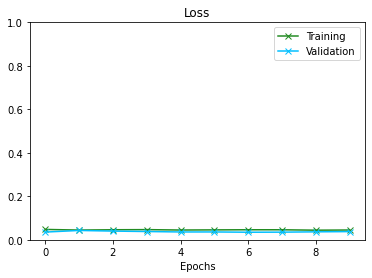

In [ ]:
#Plot Loss Curves
plot_loss_curves(history)

##Saving the Model

In [ ]:
#Saving model to google drive
path = '/content/drive/MyDrive/Colab Notebooks/self_driving_car/model'
#Make path if it doesnot exist
os.makedirs(path)
#Save model
model.save(path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/self_driving_car/driving_logs/model/assets


In [ ]:
#Saving a model locally 
model.save('model.h5')